In [1]:
import os
import re
import glob
import yaml

import numpy as np
import pandas as pd

from math import ceil
from scipy.stats import entropy

from matplotlib.patches import Patch
import matplotlib.pyplot as plt
from matplotlib import cm

import zarr
import napari
import tifffile
import dask.array as da

from utils.utility_functions import single_channel_pyramid

plt.rcParams['font.family'] = 'Arial'

In [2]:
clustering = 'VAE9_ROT_VIG18'

In [3]:
# I/O
sample = 'CRC-097'

# read single-cell data
main = pd.read_csv(os.path.join(os.getcwd(), 'input/main.csv'))
main = main[~main.isnull().any(axis=1)]  # removing cells for which KNN classes were not defined
main = main[main[clustering] != -1]  # removing any unclustered cells

# read OME-TIFF, segmentation outlines, and H&E channels
tif_path = os.path.join(os.getcwd(), f'input/{sample}_image.ome.tif')
seg_path = os.path.join(os.getcwd(), f'input/{sample}_seg_outlines.ome.tif')
he_path = os.path.join(os.getcwd(), 'input/hema_eosin.ome.tif')

# import markers.csv
markers = pd.read_csv(os.path.join(os.getcwd(), 'input/CRC-097_mcmicro_markers.csv'))

# get markers excluded from analysis
with open(os.path.join(os.getcwd(), 'input/CRC-97_cylinter_config.yml')) as f:
    config = yaml.safe_load(f)
markers_to_exclude = config['markersToExclude']

# import image contrast settings
with open(os.path.join(os.getcwd(), 'input/CRC-097_cylinter_contrast_limits.yml')) as f:
    contrast_limits = yaml.safe_load(f)

# The parquet file at the path below is being read because "main.csv" 
# uses trimmed marker channel names as column headers that differ from the raw channel names used 
# in the markers.csv file, which is itself used to index channels in the OME-TIFF image.
for_channels = pd.read_parquet(
    os.path.join(os.getcwd(), 'input/CRC-097_clean_cylinter_clustering_3d_leiden.parquet')
)

# isolate antibodies of interest
abx_channels = [
    i for i in for_channels.columns if 'nucleiRingMask' in i if
    'Hoechst' not in i if i not in markers_to_exclude
]

# get name of first DNA channel
dna1 = markers['marker_name'][markers['channel_number'] == 1][0]
dna_moniker = str(re.search(r'[^\W\d]+', dna1).group())

out = os.path.join(os.getcwd(), f'output/knn/{clustering}')
if not os.path.exists(out):
    os.makedirs(out)

In [4]:
# assign clusters to KNN classes
cluster_class_dict = {}
for cluster, group in main.groupby(clustering):

    means = []
    
    for cls in ['Prob_Normal', 'Prob_Glandular', 'Prob_Solid', 'Prob_Mucin']:
        means.append(group[cls].mean())
    
    max_value = np.argmax(means)
    
    if max_value == 0:
        cluster_class_dict[cluster] = ('Normal', means)
    elif max_value == 1:
        cluster_class_dict[cluster] = ('Glandular', means)
    elif max_value == 2:
        cluster_class_dict[cluster] = ('Solid', means)
    elif max_value == 3:
        cluster_class_dict[cluster] = ('Mucinous', means)

# convert dict to dataframe and save
cluster_class_df = pd.DataFrame.from_dict(cluster_class_dict).T

probs = pd.DataFrame(
    cluster_class_df[1].to_list(),
    columns=['Prob_Normal', 'Prob_Glandular', 'Prob_Solid', 'Prob_Mucin']
).astype('float32')
cluster_class_df.drop(columns=1, inplace=True)
cluster_class_df.reset_index(inplace=True)
cluster_class_df = pd.concat([cluster_class_df, probs], axis=1)
cluster_class_df.rename(columns={'index': clustering, 0: 'KNN_class'}, inplace=True)

# filter cluster_class_df for tumor cell clusters
if clustering == 'VAE20_Leiden':
    tumor = [
        1, 29, 31, 13, 51, 48, 56, 54, 24, 55, 57, 52, 53, 25, 47, 27, 49, 50, 46,
        15, 12, 42, 10, 32, 40, 41, 14, 11
    ]
elif clustering == 'VAE20_ROT_VIG40':
    tumor = [1, 3, 4, 5, 10, 13, 18, 22, 8, 27]
elif clustering == 'VAE9_ROT_VIG18':
    tumor = [3, 5, 6, 9, 10, 11, 14, 15, 19, 20, 24, 25, 28]

cluster_class_df = cluster_class_df[cluster_class_df[clustering].isin(tumor)]
cluster_class_df.reset_index(drop=True, inplace=True)
cluster_class_df.to_csv(os.path.join(out, f'{clustering}_KNN_classes.csv'), index=False)

In [5]:
# compute kNN class entropy scores 
entropies = {}
bar = pd.DataFrame(columns=['Prob_Glandular', 'Prob_Solid', 'Prob_Mucin'])
for cluster, group in main.groupby(clustering):
    if cluster in tumor:
        means = []
        for cls in ['Prob_Solid', 'Prob_Mucin', 'Prob_Glandular']:
            means.append(group[cls].mean())
        entropies[cluster] = entropy(pk=means, base=2)
        data_dict = {header: [value] for header, value in zip(['Prob_Solid', 'Prob_Mucin', 'Prob_Glandular'], means)}
        row = pd.DataFrame(data_dict, index=[cluster])
        bar = pd.concat([bar, row], axis=0)

/var/folders/_h/pbzrx8ss6n5f031pf4hc97_w0000gp/T/ipykernel_77441/3046746604.py:12: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  bar = pd.concat([bar, row], axis=0)


In [6]:
# normalize mean cluster kNN posterior probabilites scores 0-1, sort clusters by entropy

# sort entropy dict by entropy values
entropies = dict(sorted(entropies.items(), key=lambda item: item[1]))

# pretty print the dictionary
import json
print('Cluster entropies:')
print(json.dumps(entropies, indent=4))
sd = round(np.std(list(entropies.values()), ddof=1), 2)
print(f'Standard deviation = {sd}')

bar = bar.div(bar.sum(axis=1), axis=0)
bar = bar.reindex(entropies.keys())

# rename kNN class labels
bar.columns = [i.split('_')[1][0].lower() + i.split('_')[1][1:] for i in bar.columns]

Cluster entropies:
{
    "28": 0.34521576414074917,
    "3": 0.5838423639255904,
    "15": 0.6757210403987375,
    "20": 0.9278593345273531,
    "9": 0.9947812926740539,
    "19": 0.9973300030184326,
    "25": 1.036236854785244,
    "6": 1.219650726659765,
    "24": 1.2346797456512768,
    "10": 1.2363092876346737,
    "14": 1.2553478702527825,
    "5": 1.4124505747859133,
    "11": 1.5061794913883428
}
Standard deviation = 0.34


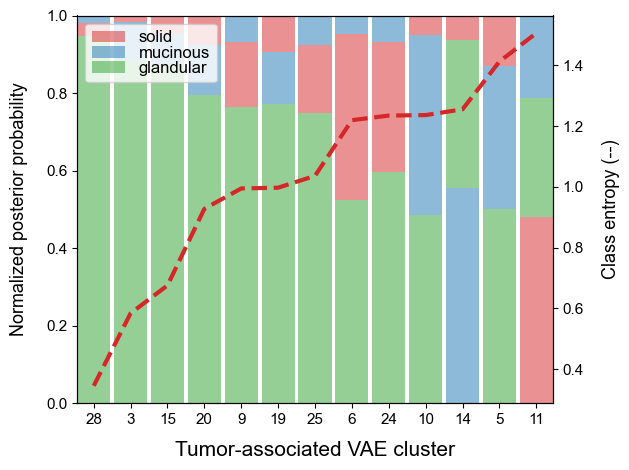

In [7]:
# plot
fig, ax1 = plt.subplots()  # figsize=(11, 5)
ax2 = ax1.twinx()
x = bar.index.astype('str')
indexes = np.argsort(bar.values).T
heights = np.sort(bar.values).T
order = -1
bottoms = heights[::order].cumsum(axis=0)
bottoms = np.insert(bottoms, 0, np.zeros(len(bottoms[0])), axis=0)

# make color dict
# normal = ['normal'] 
solid = ['solid']
mucin = ['mucin']
glandular = ['glandular']
mpp_colors = {}
# mpp_colors.update({str(k): v for k, v in zip(normal, ['tab:blue']*len(normal))})
mpp_colors.update({str(k): v for k, v in zip(solid, ['tab:red']*len(solid))})
mpp_colors.update({str(k): v for k, v in zip(mucin, ['tab:blue']*len(mucin))})
mpp_colors.update({str(k): v for k, v in zip(glandular, ['tab:green']*len(glandular))})

for btms, (idxs, vals) in enumerate(list(zip(indexes, heights))[::order]):

    mps = np.take(np.array(bar.columns), idxs)

    # IF YOU DONT WANT TO COLOR THE BARS, USE THIS CODE
    # g = ax1.bar(
    #     x, height=vals, width=0.9, color='w', lw=0.1, ec='k',
    #     bottom=bottoms[btms]
    #     )

    g = ax1.bar(
        x, height=vals, width=0.9, lw=0.5, bottom=bottoms[btms],
        color=[mpp_colors[m] for m in mps], alpha=0.5
        )
    
    # ANNOTATE BARS 
    # pos = -1
    # for i, b in enumerate(g.patches):
    #     if i % len(bar.index) == 0:
    #         pos += 1
    #     xloc = b.get_x() + 0.45
    #     yloc = b.get_y() + b.get_height()/2
    #     if b.get_height() > 0.05:
    #         ax1.annotate(
    #             mps[i], xy=(xloc, yloc), fontname='Arial',
    #             va='center', ha='center', size=9
    #             )

ax1.set_ylim(0, 1.0)
ax1.set_xlabel('Tumor-associated VAE cluster', size=15, labelpad=10)
ax1.set_ylabel('Normalized posterior probability', size=13, labelpad=13, c='k')
ax1.tick_params(axis='x', which='major', labelsize=11)
ax1.tick_params(axis='y', which='major', labelsize=11)
ax1.margins(x=0)

patches = [
    Patch(facecolor=color, alpha=0.5, edgecolor=None) for 
    color in ['tab:red', 'tab:blue', 'tab:green', ]
    ]

plt.legend(
    patches, ['solid', 'mucinous', 'glandular'],
    title=None, prop={'size': 12},
    labelspacing=0.01, loc='upper left'
    ) # bbox_to_anchor=[-0.8, 1.0], 

ax2.plot(
    [str(i) for i in entropies.keys()], entropies.values(),
    c='tab:red', lw=3, linestyle='--'
    )
ax2.set_ylabel('Class entropy (--)', size=13, labelpad=13, c='k')
ax2.tick_params(axis='both', which='major', labelsize=11)

plt.tight_layout()
fig.savefig(os.path.join(out, 'kNN_class_entropy.pdf'))
plt.show()
plt.close('all')

In [8]:
# view kNN posterior probability scores in image viewer

# add H&E image (separate RGB channels)
for color, channel in zip(['red', 'green', 'blue'], [0, 1, 2]):

    img, min, max = single_channel_pyramid(glob.glob(he_path)[0], channel=channel)

    if channel == 0:
        viewer = napari.view_image(
            img, rgb=False, colormap=color, blending='additive',
            visible=False, name=f'H&E_{color}'
        )
    else:
        viewer.add_image(
            img, rgb=False, colormap=color, blending='additive',
            visible=False, name=f'H&E_{color}'
        )

# read DNA1 channel
dna, min, max = single_channel_pyramid(glob.glob(tif_path)[0], channel=0)

# add DNA1 channel to Napari image viewer
viewer.add_image(
    dna, rgb=False, blending='additive', colormap='gray',
    visible=True, opacity=1.0, name='DNA1', contrast_limits=(min, max)
)

# loop over antibodies of interest and add to image viewer
for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    channel_number = markers['channel_number'][markers['marker_name'] == ch]
    img, min, max = single_channel_pyramid(
        glob.glob(tif_path)[0], channel=(channel_number.item() - 1)
    )
    viewer.add_image(
        img, rgb=False, blending='additive', colormap='green', visible=False, name=ch, contrast_limits=(min, max)
    )

# apply previously defined contrast limits
for ch in abx_channels:
    ch = ch.rsplit('_', 1)[0]
    viewer.layers[ch].contrast_limits = (
        contrast_limits[ch][0], contrast_limits[ch][1])

# map clusters to color categories and add centroids for tumor clusters to image viewer
num_colors = len(list(cm.tab20.colors))
num_clusters = len(main[clustering].unique())
palette_multiplier = ceil(num_clusters / num_colors)
colors = list(cm.tab20.colors) * palette_multiplier
colors = colors[0:num_clusters]
colors.reverse()

color_dict = dict(zip(sorted(main[clustering].unique(), reverse=True), colors))

for cls in ['Glandular', 'Solid', 'Mucinous', 'Normal']:

    clusters = [k for k, v in cluster_class_dict.items() if v[0] == cls]
    clusters = sorted([i for i in clusters if i in tumor], reverse=True)
    
    for i in clusters:
        centroids = main[['Y_centroid', 'X_centroid']][main[clustering] == i]
        viewer.add_points(
            centroids, name=f'{clustering}_{i}_{cluster_class_dict[i][0]}',
            face_color=np.array(color_dict[i]), edge_width=0.0,
            size=60.0, opacity=1.0, blending='translucent', visible=False
        )

# colormap centroids by KNN class posterior probabilities
for cls in ['Prob_Mucin', 'Prob_Solid', 'Prob_Glandular', 'Prob_Normal']:

    centroids = main[['Y_centroid', 'X_centroid']]
    point_properties = {'probability': main[cls]}

    viewer.add_points(
        centroids, name=cls, properties=point_properties,
        face_color='probability', face_colormap='viridis',
        edge_width=0.0, size=60.0, opacity=1.0, blending='translucent',
        visible=False
    )

# read segmentation outlines
seg, min, max = single_channel_pyramid(glob.glob(seg_path)[0], channel=0)
viewer.add_image(
    seg, rgb=False, blending='additive', colormap='gray', visible=False, 
    name='segmentation', opacity=1.0, contrast_limits=(min, max)
)

# run Napari image viewer
viewer.scale_bar.visible = True
viewer.scale_bar.unit = 'um'

napari.run()